## Data Collection


In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
import nltk
from nltk import word_tokenize
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,\
 MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes,\
 neighbors, ensemble, neural_network, svm
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import tensorflow as tf
from gaminet import GAMINet
from gaminet.utils import plot_trajectory, plot_regularization,\
 local_visualize, global_visualize_density,\
 feature_importance_visualize
import matplotlib.pyplot as plt
import re
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight
from collections import Counter
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import time
import plotly.express as px
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
import shap
import networkx as nx
import matplotlib.pyplot as plt
import torch
import requests
import json

In [2]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout

In [3]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import InMemoryDataset, Data

In [42]:
excel_file = r'C:\Users\colte\OneDrive\Documents\Research\AnalysisofComplexNetwork.xlsx'
sheet_1 = 'Sheet1'
workbook = load_workbook(excel_file, read_only=False, data_only=False, keep_links=True)
sheet = workbook[sheet_1]
data=[]
for row in sheet.iter_rows(values_only=True): data.append(row)
workbook.close()
df = pd.read_excel(excel_file, header=0)

## Disgenet

In [5]:
auth_params = {"email":"yusuf.akbulut@ndsu.edu","password":"6Wk^@LgZn%5cC$"}

api_host = "https://www.disgenet.org/api"

# api_key = "82649022b4f98dbe4561d9227bce96b1ebfd02e1"
s = requests.Session()

try:
    r = s.post(api_host+'/auth/', data=auth_params)
    if(r.status_code == 200):
        #Lets store the api key in a new variable and use it again in new requests
        json_response = r.json()
        api_key = json_response.get("token")
        print(api_key + "This is your user API key.") #Comment this line if you don't want your API key to show up in the terminal
    else:
        print(r.status_code)
        print(r.text)
except requests.exceptions.RequestException as req_ex:
    print(req_ex)
    print("Something went wrong with the request.")

if api_key:
    #Add the api key to the requests headers of the requests Session object in order to use the restricted endpoints.
    s.headers.update({"Authorization": "Bearer %s" % api_key}) 
    #Lets get all the diseases associated to a gene eg. APP (EntrezID 351) and restricted by a source.
    gda_response = s.get(api_host+'/vda/gene/ABAT', params={'source':'UNIPROT'})
    print(gda_response.json())

if s:
    s.close()

82649022b4f98dbe4561d9227bce96b1ebfd02e1This is your user API key.
[{'variantid': 'rs121434578', 'gene_symbol': 'ABAT', 'variant_dsi': '1.0', 'variant_dpi': '0.08', 'variant_consequence_type': 'missense variant', 'diseaseid': 'C0342708', 'disease_name': 'Gamma aminobutyric acid transaminase deficiency', 'disease_class': 'C16;C18', 'disease_class_name': '   Congenital, Hereditary, and Neonatal Diseases and Abnormalities;    Nutritional and Metabolic Diseases', 'disease_type': 'disease', 'disease_semantic_type': 'Disease or Syndrome', 'score': 0.8, 'ei': 1.0, 'year_initial': 1999, 'year_final': 2013, 'source': 'UNIPROT'}]


In [6]:
all_data = []
with requests.Session() as s:
    if api_key:
        s.headers.update({"Authorization": "Bearer %s" % api_key})
for protein in df["Protein Name"]:
        try:
            response = s.get(api_host + '/vda/gene/' + protein)
            # Check if the response is successful
            if response.status_code == 200:
                data = response.json()
                if data:  # Check if data is not empty
                    all_data.append(data[0])
                else:
                    print(f"No data returned for {protein}")
            else:
                print(f"Failed to retrieve data for {protein}")
        except requests.RequestException as e:
            print(f"Request failed for {protein}: {e}")

df_disgenet = pd.DataFrame(all_data)
print(df_disgenet)

Failed to retrieve data for AASDH
Failed to retrieve data for ACOT12
Failed to retrieve data for ACOX3
Failed to retrieve data for ACSS3
Failed to retrieve data for ADH1A
Failed to retrieve data for ADH6
Failed to retrieve data for ADHFE1
Failed to retrieve data for ALDH3B2
Failed to retrieve data for ALYREF
Failed to retrieve data for AOC2
Failed to retrieve data for AOC3
Failed to retrieve data for ARMC7
Failed to retrieve data for ATG4D
Failed to retrieve data for AWAT2
Failed to retrieve data for BMI1
Failed to retrieve data for CASC3
Failed to retrieve data for CCDC130
Failed to retrieve data for CCNA1
Failed to retrieve data for CCNB1IP1
Failed to retrieve data for CCNB2
Failed to retrieve data for CCNC
Failed to retrieve data for CCNE2
Failed to retrieve data for CD2BP2
Failed to retrieve data for CENPS
Failed to retrieve data for CHERP
Failed to retrieve data for CIAO2B
Failed to retrieve data for CLEC18C
Failed to retrieve data for CMPK2
Failed to retrieve data for CNOT10
Fail

In [7]:
protein_info = [{
   "Protein Name": "",
        "Consequence": "",
        "Disease Class": "",
        "VariantDisease Association Score": "",
        "biological_process": "",
        "molecular_function": "",
        "disease": ""
}
]

In [8]:
for i in df["Protein Name"]:
    protein_info.append({
        "Protein Name": i,
        "Consequence": "",
        "Disease Class": "",
        "VariantDisease Association Score": "",
        "biological_process": "",
        "molecular_function": "",
        "disease": ""
    })

In [9]:
for protein in protein_info:
    matching_entry = df_disgenet[df_disgenet['gene_symbol'] == protein['Protein Name']]
    if not matching_entry.empty:
        protein['Consequence'] = matching_entry['variant_consequence_type'].values[0]
        protein['Disease Class'] = matching_entry['disease_class'].values[0]
        protein['VariantDisease Association Score'] = matching_entry['score'].values[0]
        protein['disease'] = matching_entry['disease_name'].values[0]
    else:
        protein['Consequence'] = 'Not available'
        protein['Disease Class'] = 'Not available'
        protein['VariantDisease Association Score'] = 'Not available'
        protein['disease'] = 'Not available'

In [10]:
pd.DataFrame(protein_info)

Protein Name          Consequence  Disease Class  \
0                        Not available  Not available   
1             A2M        Not available  Not available   
2            AAR2       intron variant           None   
3           AASDH        Not available  Not available   
4            ABAT     missense variant        C16;C18   
...           ...                  ...            ...   
1211       ZNF462          stop gained            C11   
1212       ZNF830        Not available  Not available   
1213        ZNRD1  3 prime UTR variant        C01;C20   
1214        ZNRF3  3 prime UTR variant           None   
1215        ZRSR2        Not available  Not available   

     VariantDisease Association Score biological_process molecular_function  \
0                       Not available                                         
1                       Not available                                         
2                                 0.7                                         
3                       Not available                                         
4                                 0.8                                         
...                               ...                ...                ...   
1211                              0.7                                         
1212                    Not available                                         
1213                              0.8                                         
1214                              0.8                                         
1215                    Not available                                         

                                              disease  
0                                       Not available  
1                                       Not available  
2                                         Body Height  
3                                       Not available  
4     Gamma aminobutyric acid transaminase deficiency  
...                                               ...  
1211                                   Blepharoptosis  
1212                                    Not available  
1213               Acquired Immunodeficiency Syndrome  
1214                                  Waist-Hip Ratio  
1215                                    Not available  

[1216 rows x 7 columns]

## Protein Atlas

In [11]:
for protein in protein_info:
    protein_name = protein['Protein Name']
    url = f"https://www.proteinatlas.org/api/search_download.php?search={protein_name}&format=json&columns=upbp,up_mf&compress=no"
    
    response = requests.get(url)
    data = response.json()

    if data:  # Check if data is not empty
        first_record = data[0]  # Get the first record

        protein['biological_process'] = first_record.get('Biological process', 'Not available')
        protein['molecular_function'] = first_record.get('Molecular function', 'Not available')
    else:
        protein['biological_process'] = 'Not available'
        protein['molecular_function'] = 'Not available'

pd.DataFrame(protein_info)

Protein Name          Consequence  Disease Class  \
0                        Not available  Not available   
1             A2M        Not available  Not available   
2            AAR2       intron variant           None   
3           AASDH        Not available  Not available   
4            ABAT     missense variant        C16;C18   
...           ...                  ...            ...   
1211       ZNF462          stop gained            C11   
1212       ZNF830        Not available  Not available   
1213        ZNRD1  3 prime UTR variant        C01;C20   
1214        ZNRF3  3 prime UTR variant           None   
1215        ZRSR2        Not available  Not available   

     VariantDisease Association Score  \
0                       Not available   
1                       Not available   
2                                 0.7   
3                       Not available   
4                                 0.8   
...                               ...   
1211                              0.7   
1212                    Not available   
1213                              0.8   
1214                              0.8   
1215                    Not available   

                                     biological_process  \
0                                                  None   
1                                                  None   
2                      [mRNA processing, mRNA splicing]   
3             [Fatty acid metabolism, Lipid metabolism]   
4                        [Neurotransmitter degradation]   
...                                                 ...   
1211          [Transcription, Transcription regulation]   
1212  [Cell cycle, Cell division, Mitosis, mRNA proc...   
1213                                    [Transcription]   
1214   [Ubl conjugation pathway, Wnt signaling pathway]   
1215                   [mRNA processing, mRNA splicing]   

                                   molecular_function  \
0                                                None   
1     [Protease inhibitor, Serine protease inhibitor]   
2                                                None   
3                                            [Ligase]   
4                     [Aminotransferase, Transferase]   
...                                               ...   
1211                                    [DNA-binding]   
1212                          [Developmental protein]   
1213                                             None   
1214             [Developmental protein, Transferase]   
1215                 [Ribonucleoprotein, RNA-binding]   

                                              disease  
0                                       Not available  
1                                       Not available  
2                                         Body Height  
3                                       Not available  
4     Gamma aminobutyric acid transaminase deficiency  
...                                               ...  
1211                                   Blepharoptosis  
1212                                    Not available  
1213               Acquired Immunodeficiency Syndrome  
1214                                  Waist-Hip Ratio  
1215                                    Not available  

[1216 rows x 7 columns]

In [ ]:
for protein in protein_info:
    protein_name = protein['protein_name']
    url = f"https://www.proteinatlas.org/api/search_download.php?search={protein_name}&format=json&columns=upbp,up_mf&compress=no"
    
    response = requests.get(url)

    # Check if the response status code indicates success
    if response.status_code == 200:
        try:
            data = response.json()

            if data:  # Check if data is not empty
                first_record = data[0]  # Get the first record
                protein['biological_process'] = first_record.get('Biological process', 'Not available')
                protein['molecular_function'] = first_record.get('Molecular function', 'Not available')
            else:
                protein['biological_process'] = 'Not available'
                protein['molecular_function'] = 'Not available'

        except ValueError:  # Catch JSON decode error
            print(f"Error decoding JSON for protein {protein_name}")
            protein['biological_process'] = 'JSON error'
            protein['molecular_function'] = 'JSON error'
    else:
        print(f"Failed to retrieve data for {protein_name} (Status Code: {response.status_code})")
        protein['biological_process'] = 'Not available'
        protein['molecular_function'] = 'Not available'

pd.DataFrame(protein_info)

In [12]:
protein_info_df = pd.DataFrame(protein_info)
protein_info_df = protein_info_df.iloc[1:]

## Uniprot

In [ ]:
#url = 'https://rest.uniprot.org/uniprotkb/search?query=ACR AND organism_id:9606&format=json'
#aaa = requests.get(url).json()

In [ ]:
#with open('data.json', 'w') as f:
    #json.dump(aaa, f)

In [ ]:
#print(aaa["results"][0]["comments"][8]["texts"][0]["value"])

In [ ]:
#for protein in protein_info:
    #protein_name = protein['protein_name']
   # url = 'https://rest.uniprot.org/uniprotkb/search?query={protein_name} AND organism_id:9606&format=json'
    #response = requests.get(url)
    #data = response.json()
    #if data:
        #text_value = data["results"][0]["comments"][8]["texts"][0]["value"]
       # protein['Family'] = text_value
   # else:
        #protein['Family'] = 'Not available' 
        
#pd.DataFrame(protein_info)

## Data Merging

In [43]:
df = pd.merge(df, protein_info_df, on='Protein Name', how='left')

In [44]:
df

Protein Name       Class  Degree  Closeness  Eccentricity  \
0             A2M  Microsomia      37   0.430654             4   
1            AAR2  Microsomia      43   0.385423             4   
2           AASDH         FAS      72   0.440044             4   
3            ABAT         FAS      61   0.391403             5   
4           ABCB1         FAS      83   0.481702             4   
...           ...         ...     ...        ...           ...   
1210       ZNF462    Microtia       2   0.343351             5   
1211       ZNF830  Microsomia      36   0.373190             4   
1212        ZNRD1    Microtia      45   0.420486             5   
1213        ZNRF3    Microtia       9   0.383228             4   
1214        ZRSR2  Microsomia      63   0.441810             5   

      Clustering Coefficient  Stress  Neighborhood Connectivity  Betweeness  \
0                   0.478979   23204                  84.486486    0.000370   
1                   0.805094    2838                 129.023256    0.000044   
2                   0.259781  144694                  77.125000    0.002792   
3                   0.444262   19258                  65.278689    0.000258   
4                   0.369380  205122                 108.771084    0.002351   
...                      ...     ...                        ...         ...   
1210                1.000000       0                 112.500000    0.000000   
1211                0.784127    3752                 110.388889    0.000051   
1212                0.583838   30720                  99.022222    0.000283   
1213                0.888889      42                 117.222222    0.000001   
1214                0.467486   68206                 122.190476    0.000764   

      Radiality  # Undirected edges  Topological Coefficeint   Nucleus  \
0      0.996593                  37                 0.107080  3.106947   
1      0.995890                  43                 0.269923  4.496513   
2      0.996720                  72                 0.095082  3.467521   
3      0.995992                  61                 0.131610  1.427131   
4      0.997227                  83                 0.104890  4.727531   
...         ...                 ...                      ...       ...   
1210   0.995071                   2                 0.576923  4.794509   
1211   0.995671                  36                 0.254940  4.833653   
1212   0.996448                  45                 0.137691  4.489464   
1213   0.995852                   9                 0.248352  2.396372   
1214   0.996744                  63                 0.146336  5.000000   

      Plasma Membrane  Mitochondrion  Extracellular Target Family     Blood  \
0            2.953353       2.022159       4.801142         Other  4.508348   
1            0.000000       0.915145       0.000000         Other  1.248721   
2            2.217035       2.475034       1.985332        Enzyme  4.420086   
3            1.281186       5.000000       1.272443        Enzyme  2.197468   
4            5.000000       2.511888       4.529935   Transporter  3.412581   
...               ...            ...            ...           ...       ...   
1210         0.000000       0.570320       0.716417         Other  1.586247   
1211         0.000000       0.000000       0.000000         Other  0.833333   
1212         0.809397       0.932267       2.699825        Enzyme  1.520159   
1213         5.000000       1.218408       1.725486        Enzyme  2.099363   
1214         1.269740       1.282395       0.874721         Other  2.193321   

          Bone  Bone Marrow  Cytoskeleton   Cytosol     Heart    Kidney  \
0     1.920423     4.419371      2.171801  3.028892  4.121958  4.076944   
1     0.000000     0.988262      0.623346  2.904587  0.982271  1.496765   
2     0.977560     1.297192      1.518176  3.597633  2.622031  2.407107   
3     0.695110     0.124939      1.064494  1.855989  2.122865  2.647208   
4     1.973640     2.465656      2.591809  3.39093

## Sequence Info

In [45]:
seq_records = []
for index, row in df.iterrows():
    protein_name = row['Protein Name']
    protein_sequence = row['Sequence'].replace('\n', '')
    seq = Seq(protein_sequence)
    record = SeqRecord(seq, id=protein_name, description='')
    seq_records.append(record)

In [46]:
fasta_file_path = 'protein_sequences.fasta'
with open(fasta_file_path, 'w') as output_file:
    SeqIO.write(seq_records, output_file, 'fasta')

In [47]:
sequences = []
with open(fasta_file_path, 'r') as fasta:
    for record in SeqIO.parse(fasta, 'fasta'):
        sequence_id = record.id
        sequence_description = record.description
        sequence = str(record.seq) 
        sequences.append({'ID': sequence_id,'Description': sequence_description,'Sequence': sequence})

In [48]:
for seq_info in sequences:
    print(f"ID: {seq_info['ID']}")
    print(f"Description: {seq_info['Description']}")
    print(f"Sequence: {seq_info['Sequence']}")
    print()

ID: A2M
Description: A2M
Sequence: MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEKGCVLLSYLNETVTVSASLESVRGNRSLFTDLEAENDVLHCVAFAVPKSSSNEEVMFLTVQVKGPTQEFKKRTTVMVKNEDSLVFVQTDKSIYKPGQTVKFRVVSMDENFHPLNELIPLVYIQDPKGNRIAQWQSFQLEGGLKQFSFPLSSEPFQGSYKVVVQKKSGGRTEHPFTVEEFVLPKFEVQVTVPKIITILEEEMNVSVCGLYTYGKPVPGHVTVSICRKYSDASDCHGEDSQAFCEKFSGQLNSHGCFYQQVKTKVFQLKRKEYEMKLHTEAQIQEEGTVVELTGRQSSEITRTITKLSFVKVDSHFRQGIPFFGQVRLVDGKGVPIPNKVIFIRGNEANYYSNATTDEHGLVQFSINTTNVMGTSLTVRVNYKDRSPCYGYQWVSEEHEEAHHTAYLVFSPSKSFVHLEPMSHELPCGHTQTVQAHYILNGGTLLGLKKLSFYYLIMAKGGIVRTGTHGLLVKQEDMKGHFSISIPVKSDIAPVARLLIYAVLPTGDVIGDSAKYDVENCLANKVDLSFSPSQSLPASHAHLRVTAAPQSVCALRAVDQSVLLMKPDAELSASSVYNLLPEKDLTGFPGPLNDQDNEDCINRHNVYINGITYTPVSSTNEKDMYSFLEDMGLKAFTNSKIRKPKMCPQLQQYEMHGPEGLRVGFYESDVMGRGHARLVHVEEPHTETVRKYFPETWIWDLVVVNSAGVAEVGVTVPDTITEWKAGAFCLSEDAGLGISSTASLRAFQPFFVELTMPYSVIRGEAFTLKATVLNYLPKCIRVSVQLEASPAFLAVPVEKEQAPHCICANGRQTVSWAVTPKSLGNVNFTVSAEALESQELCGTEVPSVPEHGRKDTVIKPLLVEPEGLEKETTFNSLLCPSGGEVSEELSLKLPPNVVEESARASVSVLGDILGSAMQNTQNL

In [49]:
pattern = r'G..AT'
sequences_with_pattern = []
with open(fasta_file_path, 'r') as fasta:
    for record in SeqIO.parse(fasta, 'fasta'):
        sequence = str(record.seq)
        if re.search(pattern, sequence):
            sequences_with_pattern.append(record)
for record in sequences_with_pattern:
    print(f"ID: {record.id}")
    #print(f"Description: {record.description}")
    #print(f"Sequence: {record.seq}")
    print()

ID: ABAT

ID: ABCB1

ID: ACACB

ID: ACLY

ID: ACOX3

ID: ACSS2

ID: ADH7

ID: AGA

ID: AGXT

ID: AKR1B10

ID: ALDH3A1

ID: ALDH9A1

ID: ALOX15B

ID: AOC2

ID: AOC3

ID: APC

ID: APOB

ID: ARID1B

ID: ATG13

ID: ATG9B

ID: AVPR1B

ID: AWAT2

ID: BMI1

ID: BMPR2

ID: CBR1

ID: CBX2

ID: CDK8

ID: CENPJ

ID: CHD8

ID: CMPK2

ID: CNDP1

ID: COG4

ID: COG5

ID: COG6

ID: COG7

ID: CTH

ID: CYB5A

ID: CYB5B

ID: CYP2A13

ID: CYP2A6

ID: CYP7A1

ID: DCHS1

ID: DMGDH

ID: DPYD

ID: EAPP

ID: EFTUD2

ID: EGF

ID: EIF4A3

ID: EP300

ID: ESR1

ID: F2

ID: FAAP100

ID: FANCE

ID: FGA

ID: FGB

ID: FGF5

ID: FOS

ID: FTCD

ID: FZD8

ID: GAB1

ID: GATA1

ID: GLS

ID: GLUL

ID: GMPS

ID: GPR143

ID: GRM2

ID: GRM4

ID: GRM5

ID: GRM6

ID: GRM7

ID: GRM8

ID: GSTM5

ID: HCFC1

ID: HDAC4

ID: HECTD4

ID: HIVEP3

ID: HSPG2

ID: IBSP

ID: ITGA6

ID: ITGB4

ID: KDM1A

ID: KDM6A

ID: KMT2A

ID: KMT2B

ID: KMT2C

ID: KMT2D

ID: LRP8

ID: MAP1B

ID: MBD5

ID: MCM10

ID: MCM4

ID: MCM6

ID: MECP2

ID: MED16



In [50]:
sequence_lengths = {}
with open(fasta_file_path, 'r') as fasta:
    for record in SeqIO.parse(fasta, 'fasta'):
        sequence_id = record.id
        sequence_length = len(record.seq)
        sequence_lengths[sequence_id] = sequence_length
df['SequenceLength'] = df['Protein Name'].map(sequence_lengths)

In [51]:
molecular_weights = {}
with open(fasta_file_path, 'r') as fasta:
    for record in SeqIO.parse(fasta, 'fasta'):
        sequence_id = record.id
        sequence = str(record.seq)
        valid_sequence = ''.join([aa for aa in sequence if aa in 'ACDEFGHIKLMNPQRSTVWY'])
        mw = molecular_weight(sequence, 'protein')
        molecular_weights[sequence_id] = mw

In [52]:
df['MolecularWeight'] = df['Protein Name'].map(molecular_weights)

In [53]:
signal_peptide_pattern = r'[MF][KR].{3,}.[LI].{2,}[GAP].[STAG].{2,}R'
signal_peptide_counts = {}
with open(fasta_file_path, 'r') as fasta:
    for record in SeqIO.parse(fasta, 'fasta'):
        sequence = str(record.seq)
        signal_peptide_matches = re.findall(signal_peptide_pattern, sequence)
        signal_peptide_counts[record.id] = len(signal_peptide_matches)

In [54]:
signal_peptide_count_df = pd.DataFrame({'SequenceID': signal_peptide_counts.keys(),'SignalPeptideCount': signal_peptide_counts.values()})

In [55]:
dfnew = df.merge(signal_peptide_count_df, left_on='Protein Name', right_on='SequenceID', how='left')

In [56]:
dfnew.drop("SequenceID", axis=1, inplace=True)

In [57]:
df = dfnew

In [58]:
amino_acid_data = []
for record in SeqIO.parse(fasta_file_path, 'fasta'):
    protein_name = record.id
    protein_sequence = str(record.seq)
    amino_acid_count = Counter(protein_sequence)
    amino_acid_data.append({'Protein Name': protein_name, **amino_acid_count})
amino_acid_df = pd.DataFrame(amino_acid_data)
merged_df = df.merge(amino_acid_df, on='Protein Name', how='left')
df = merged_df

In [59]:
pd.set_option('display.max_columns', None)

Text(0, 0.5, 'Class')

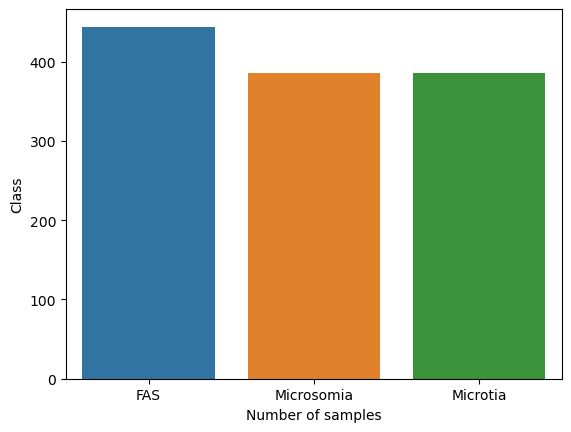

In [60]:
df_class = df['Class'].value_counts().reset_index()
df_class.columns = ['Class', 'Count']
sns.barplot(x = "Class", y = "Count", data=df_class)
plt.xlabel("Number of samples")
plt.ylabel("Class")

## Data Cleaning 

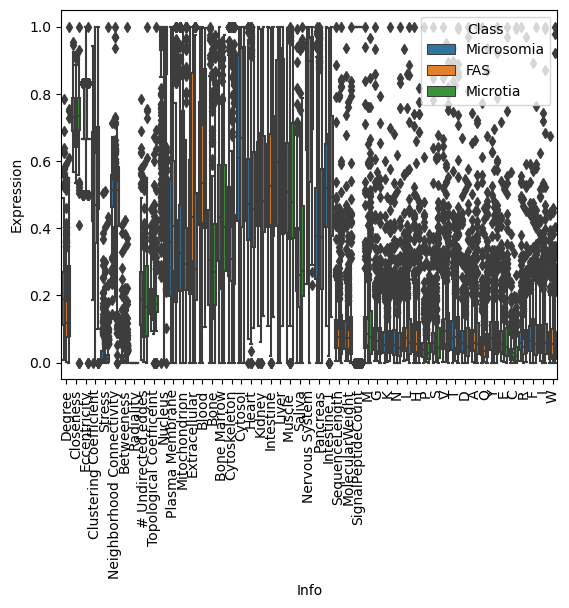

In [61]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
normalized_df = df.copy()
normalized_df[numeric_columns] = (df[numeric_columns] - df[numeric_columns].min()) / (df[numeric_columns].max() - df[numeric_columns].min())
df_m = pd.melt(normalized_df, id_vars="Class", value_vars=numeric_columns)
ax = sns.boxplot(x="variable", y="value", data=df_m, hue="Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("Info")
plt.ylabel("Expression")
plt.show()

In [63]:
df[numeric_columns] = normalized_df[numeric_columns]

In [64]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_transformed = df.copy()
df_transformed[numeric_columns] = df_transformed[numeric_columns].apply(lambda x: np.log1p(x))
print(df_transformed[numeric_columns])

        Degree  Closeness  Eccentricity  Clustering Coefficient    Stress  \
0     0.091084   0.549403      0.510826                0.391352  0.007122   
1     0.105103   0.503991      0.510826                0.590613  0.000874   
2     0.170221   0.558577      0.510826                0.230938  0.043606   
3     0.146018   0.510114      0.606136                0.367599  0.005915   
4     0.193853   0.598294      0.510826                0.314358  0.061269   
...        ...        ...           ...                     ...       ...   
1210  0.005141   0.459816      0.606136                0.693147  0.000000   
1211  0.088728   0.491346      0.510826                0.578929  0.001155   
1212  0.109732   0.539373      0.606136                0.459851  0.009418   
1213  0.022931   0.501734      0.510826                0.635989  0.000013   
1214  0.150462   0.560293      0.606136                0.383551  0.020792   

      Neighborhood Connectivity  Betweeness  Radiality  # Undirected edges 

## Data Splitting

In [65]:
column_names = df.columns
column_names_list = column_names.tolist()
print(column_names_list)

['Protein Name', 'Class', 'Degree', 'Closeness', 'Eccentricity', 'Clustering Coefficient', 'Stress', 'Neighborhood Connectivity', 'Betweeness', 'Radiality', '# Undirected edges', 'Topological Coefficeint', 'Nucleus', 'Plasma Membrane', 'Mitochondrion', 'Extracellular', 'Target Family', 'Blood', 'Bone', 'Bone Marrow', 'Cytoskeleton', 'Cytosol', 'Heart', 'Kidney', 'Intestine', 'Liver', 'Muscle ', 'Saliva', 'Nervous System', 'Pancreas', 'Intestine.1', 'Sequence', 'Family', 'Consequence', 'Disease Class', 'VariantDisease Association Score', 'biological_process', 'molecular_function', 'disease', 'SequenceLength', 'MolecularWeight', 'SignalPeptideCount', 'M', 'G', 'K', 'N', 'L', 'H', 'P', 'S', 'V', 'T', 'D', 'A', 'Q', 'Y', 'E', 'C', 'R', 'F', 'I', 'W']


In [77]:
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(map(str, lst))
    return str(lst)
for column in df.columns:
    df[column] = df[column].apply(list_to_string)
columns_to_drop = ['Protein Name', 'Class','Sequence','Family','Intestine.1','disease','Disease Class']
X = df.drop(columns=columns_to_drop, axis=1)
y = df['Class']

In [78]:
N = 20
top_n = X['molecular_function'].value_counts().index[:N]
X['molecular_function'] = X['molecular_function'].where(X['molecular_function'].isin(top_n), 'Other')
top_n = X['biological_process'].value_counts().index[:N]
X['biological_process'] = X['biological_process'].where(X['biological_process'].isin(top_n), 'Other')
X_encoded = pd.get_dummies(X, columns=['molecular_function', 'biological_process'])

In [80]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_encoded = pd.get_dummies(X_encoded, columns=['Target Family'])
X_encoded = pd.get_dummies(X_encoded, columns=['Consequence'])

In [94]:
X_encoded.replace('nan', 0, inplace=True)
X_encoded.replace('inf', 0, inplace=True)
X_encoded['VariantDisease Association Score'] = X_encoded['VariantDisease Association Score'].replace('Not available', 0)

## Model Training & Random Forest Classifier

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((972, 120), (243, 120), (972,), (243,))

In [97]:
X_train = X_train.replace({'True': True, 'False': False})
X_test = X_test.replace({'True': True, 'False': False})
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
label_encoder = LabelEncoder()
yXG_train = label_encoder.fit_transform(y_train)
yXG_test = label_encoder.fit_transform(y_test)
model_proteins = RandomForestClassifier(n_estimators=100, random_state=42)
model_proteins.fit(X_train, yXG_train)

RandomForestClassifier(random_state=42)

In [100]:
y_pred = model_proteins.predict(X_test)

In [101]:
accuracy = accuracy_score(yXG_test, y_pred)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.7366255144032922


In [103]:
kfold_cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_proteins, X_train, yXG_train, cv=kfold_cv, scoring='accuracy')
print(cv_scores)

[0.71428571 0.75510204 0.65979381 0.70103093 0.73195876 0.73195876
 0.74226804 0.69072165 0.7628866  0.75257732]


In [104]:
print({np.mean(cv_scores)})
print({np.std(cv_scores)})

{0.72425836313907}
{0.03099634456997209}


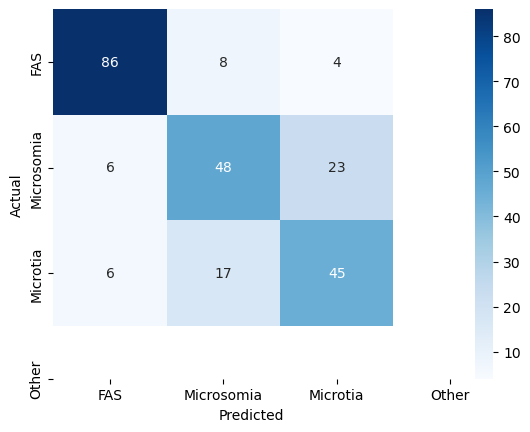

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_pred = model_proteins.predict(X_test)
cm = confusion_matrix(yXG_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['FAS','Microsomia','Microtia','Other'], 
            yticklabels=['FAS','Microsomia','Microtia','Other'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [107]:
start_time = time.time()
importances = model_proteins.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_proteins.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.039 seconds


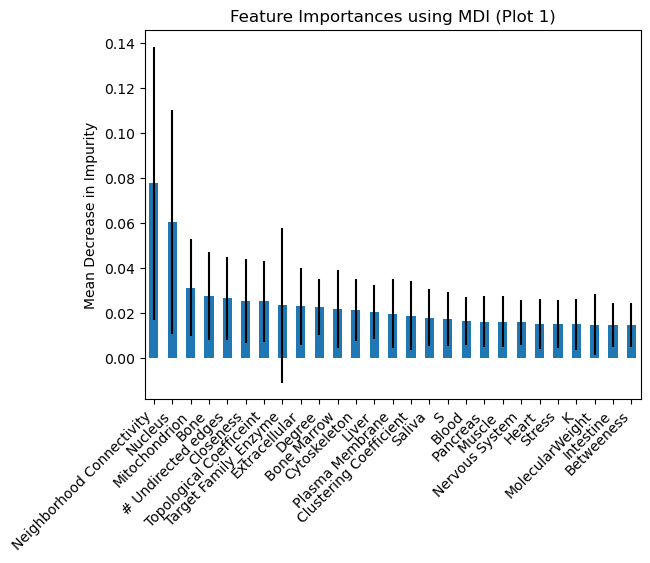

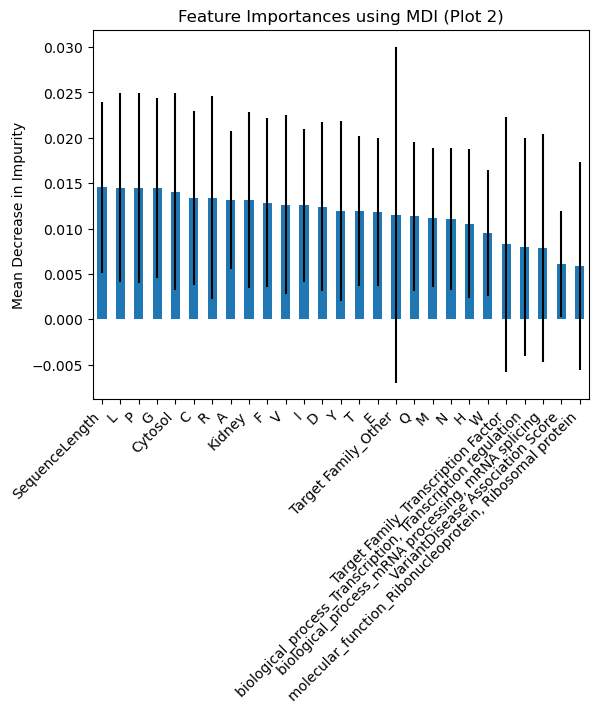

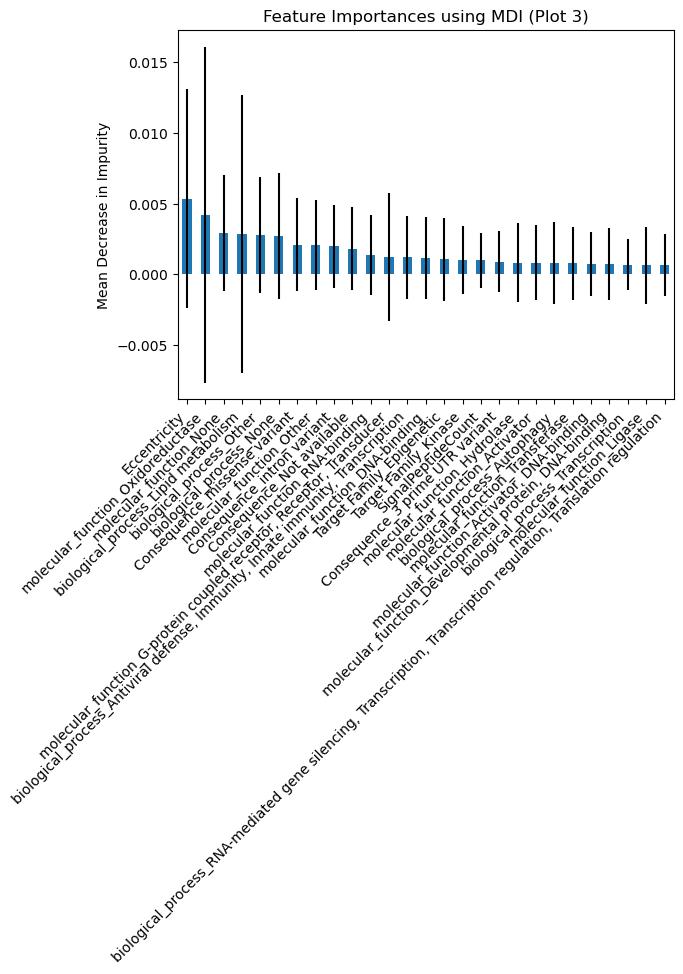

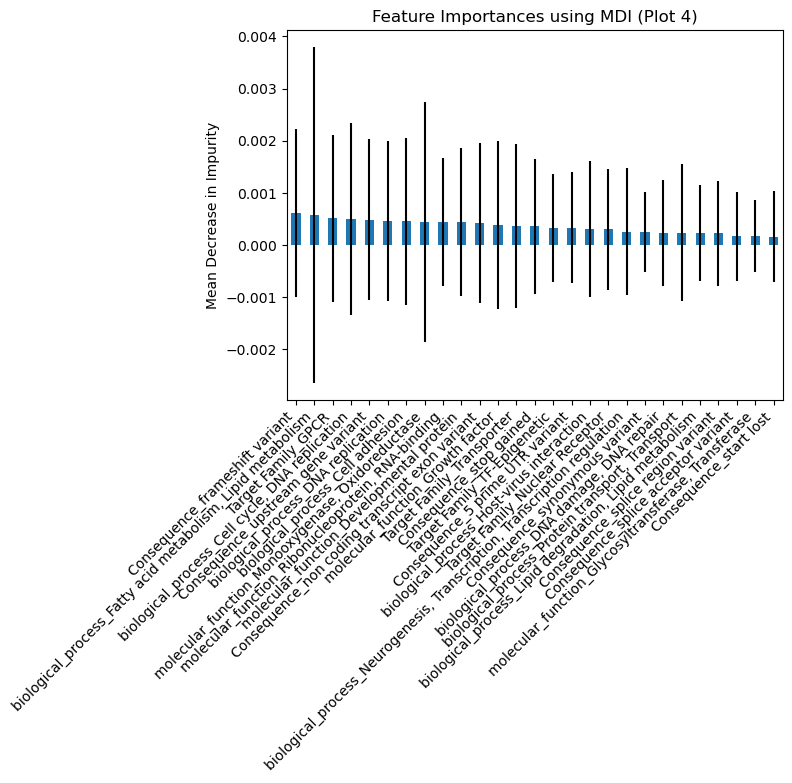

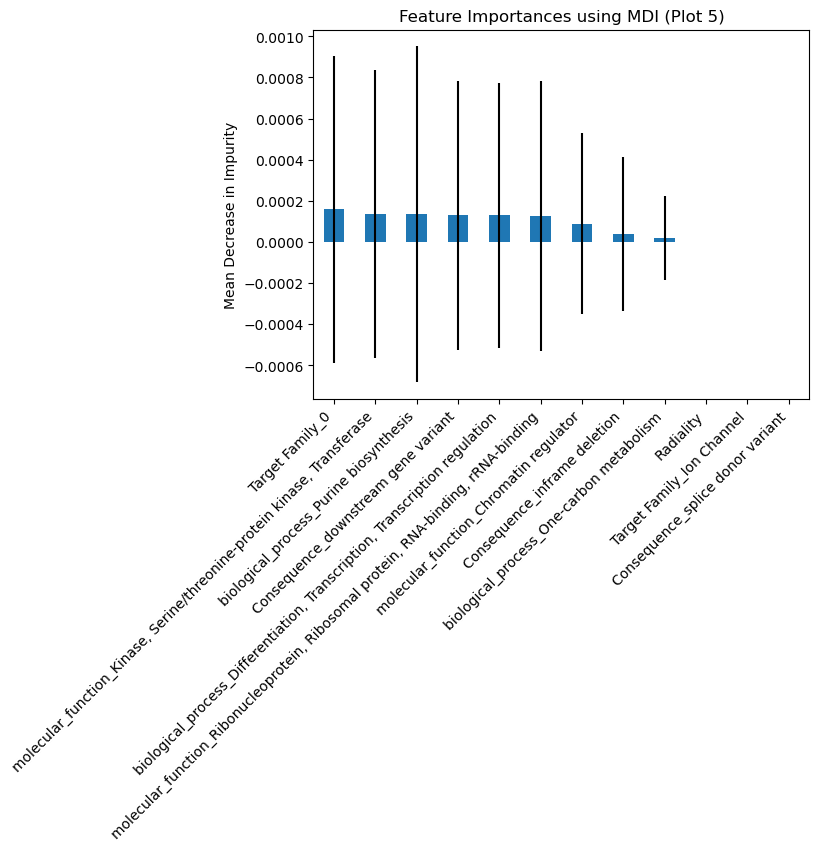

In [108]:
feature_names = X_encoded.columns.tolist()
forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending=False)
importances_index = range(len(importances))  # Create an index for the original order
sorted_index = sorted(importances_index, key=lambda i: importances[i], reverse=True)  # Sort this index based on importances
sorted_std = [std[i] for i in sorted_index]
num_features_per_plot = 27
total_plots = len(sorted_importances) // num_features_per_plot + int(len(sorted_importances) % num_features_per_plot > 0)
for i in range(total_plots):
    start_idx = i * num_features_per_plot
    end_idx = start_idx + num_features_per_plot
    subset_importances = sorted_importances[start_idx:end_idx]
    subset_std = sorted_std[start_idx:end_idx]

    fig, ax = plt.subplots()
    subset_importances.plot.bar(yerr=subset_std, ax=ax)
    ax.set_title(f"Feature Importances using MDI (Plot {i+1})")
    ax.set_ylabel("Mean Decrease in Impurity")
    ax.set_xticklabels(subset_importances.index, rotation=45, ha="right")
    plt.show()

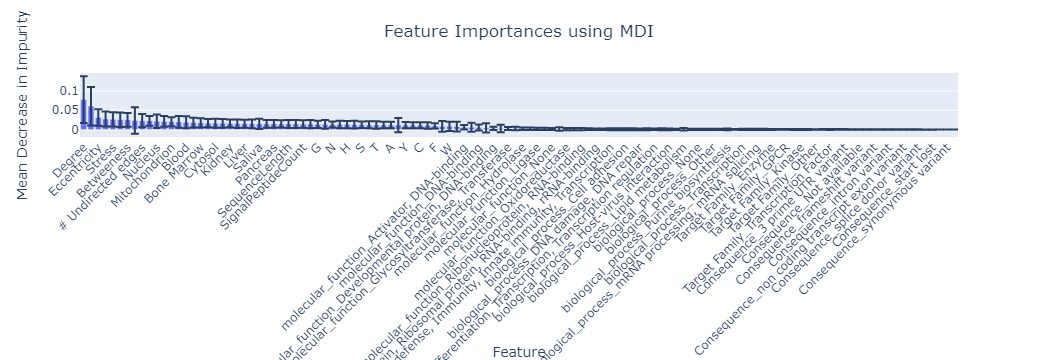

In [109]:
fig = px.bar(df, x=feature_names, y=sorted_importances.values, error_y=sorted_std,
             labels={'Features': 'Feature', 'Importances': 'Mean Decrease in Impurity'},
             title='Feature Importances using MDI')
fig.update_layout(xaxis_tickangle=-45, xaxis_title='Feature',
                  yaxis_title='Mean Decrease in Impurity', title_x=0.5)
fig.show()

## XGBoost Classifier

In [110]:
XGmodel = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42)
XGmodel.fit(X_train, yXG_train)
predictions = XGmodel.predict(X_test)
accuracy = accuracy_score(yXG_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.757201646090535


In [111]:
kfold_cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(XGmodel, X_train, yXG_train, cv=kfold_cv, scoring='accuracy')
print(cv_scores)

[0.7244898  0.70408163 0.71134021 0.73195876 0.72164948 0.74226804
 0.71134021 0.73195876 0.71134021 0.73195876]


In [112]:
print({np.mean(cv_scores)})
print({np.std(cv_scores)})

{0.722238586156112}
{0.01173046709397781}


## ADA Boost Classifier

In [113]:
adamodel = AdaBoostClassifier(n_estimators=100, random_state=42)
adamodel.fit(X_train, yXG_train)
predictions = adamodel.predict(X_test)
accuracy = accuracy_score(yXG_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6790123456790124


In [114]:
kfold_cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(adamodel, X_train, yXG_train, cv=kfold_cv, scoring='accuracy')
print(cv_scores)

[0.68367347 0.70408163 0.55670103 0.68041237 0.69072165 0.67010309
 0.63917526 0.73195876 0.59793814 0.64948454]


In [115]:
print({np.mean(cv_scores)})
print({np.std(cv_scores)})

{0.6604249947401641}
{0.04920267653265022}


## Stacked Ensemble Classifier

In [116]:
Xstack_train, Xstack_temp, ystack_train, ystack_temp = train_test_split(X_encoded, y, test_size=0.4, random_state=42)
Xstack_val, Xstack_test, ystack_val, ystack_test = train_test_split(Xstack_temp, ystack_temp, test_size=0.5, random_state=42)
yS_train = label_encoder.fit_transform(ystack_train)
yS_test = label_encoder.transform(ystack_test)
yS_val = label_encoder.transform(ystack_val)
for col in Xstack_train.columns:
    Xstack_train[col] = pd.to_numeric(Xstack_train[col], errors='coerce')
for col in Xstack_test.columns:
    Xstack_test[col] = pd.to_numeric(Xstack_test[col], errors='coerce')
for col in Xstack_val.columns:
    Xstack_val[col] = pd.to_numeric(Xstack_val[col], errors='coerce')
rf_pred = model_proteins.predict(Xstack_val)
xgb_pred = XGmodel.predict(Xstack_val)
ada_pred = adamodel.predict(Xstack_val)
stacked_predictions = np.column_stack((rf_pred, xgb_pred, ada_pred))
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(stacked_predictions, yS_val)
final_pred = meta_model.predict(np.column_stack((model_proteins.predict(Xstack_test), XGmodel.predict(Xstack_test), adamodel.predict(Xstack_test))))

In [117]:
accuracy = accuracy_score(yS_test, final_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8683127572016461


In [118]:
from sklearn.model_selection import cross_val_score, KFold
scaler = StandardScaler()
Xstack_train_scaled = scaler.fit_transform(Xstack_train)
kfold_cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(meta_model, Xstack_train_scaled, yS_train, cv=kfold_cv, scoring='accuracy')
print(cv_scores)

[0.61643836 0.61643836 0.69863014 0.71232877 0.63013699 0.67123288
 0.7260274  0.57534247 0.73972603 0.76388889]


In [119]:
print({np.mean(cv_scores)})
print({np.std(cv_scores)})

{0.6750190258751904}
{0.059551442196088905}


## GNN

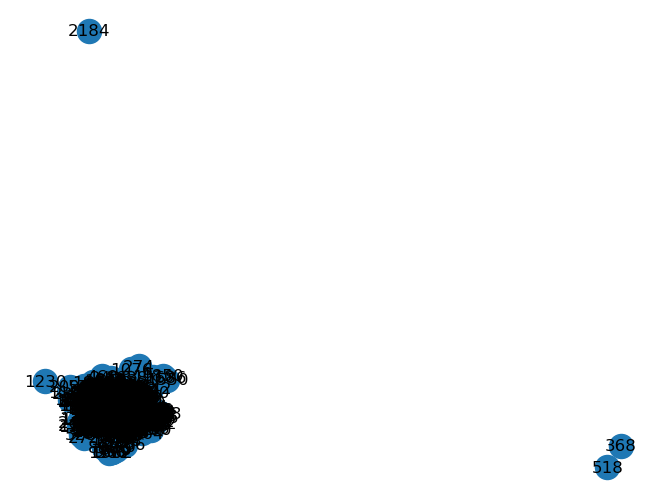

tensor([[   0,    0,    0,  ..., 1203, 1206, 1210],
        [ 319,   20, 1015,  ..., 1211, 1209, 1213]])
Shape of the tensor: torch.Size([2, 42177])


In [120]:
G = nx.read_graphml("C:/Users/colte/OneDrive/Documents/STRINGnetwork2.graphml")
G = G.to_undirected()
nx.draw(G, with_labels=True)
plt.show()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
edge_list = list(G.edges())
edge_array = [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in edge_list]
edges_tensor = torch.tensor(edge_array, dtype=torch.long).t().contiguous()
print(edges_tensor)
print("Shape of the tensor:", edges_tensor.shape)

In [121]:
X_encoded = X_encoded.astype(float)
features_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(y)
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)
data = Data(x=features_tensor, edge_index=edges_tensor, y=labels_tensor)
print(data)

Data(x=[1215, 120], edge_index=[2, 42177], y=[1215])


In [122]:
num_nodes = data.num_nodes
node_indices = torch.randperm(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.15 * num_nodes)
test_size = num_nodes - train_size - val_size
train_indices = node_indices[:train_size]
val_indices = node_indices[train_size:train_size+val_size]
test_indices = node_indices[train_size+val_size:]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
num_features = data.num_node_features
num_classes = len(np.unique(data.y.numpy()))

In [130]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()
num_classes = torch.unique(data.y).size(0)
data.num_classes = num_classes
print(data.num_classes)
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                    lr=0.01,
                                    weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask],
            data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].
            argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask],data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss:{loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss:{val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        predictions = out.argmax(dim=1)
        acc = accuracy(out.argmax(dim=1)[data.test_mask],
        data.y[data.test_mask])
        return acc, predictions
gcn = GCN(data.num_features, 64, data.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc, pred = gcn.test(data)
print(f'GCN test accuracy: {acc*100:.2f}%')
print(f'GCN predictions: {pred}')

7
GCN(
  (gcn1): GCNConv(1433, 64)
  (gcn2): GCNConv(64, 7)
)
Epoch   0 | Train Loss:1.958 | Train Acc: 12.86% | Val Loss:1.94 | Val Acc: 19.80%
Epoch  20 | Train Loss:0.005 | Train Acc: 100.00% | Val Loss:0.77 | Val Acc: 77.80%
Epoch  40 | Train Loss:0.005 | Train Acc: 100.00% | Val Loss:0.76 | Val Acc: 79.20%
Epoch  60 | Train Loss:0.012 | Train Acc: 100.00% | Val Loss:0.70 | Val Acc: 77.60%
Epoch  80 | Train Loss:0.010 | Train Acc: 100.00% | Val Loss:0.71 | Val Acc: 77.80%
Epoch 100 | Train Loss:0.010 | Train Acc: 100.00% | Val Loss:0.72 | Val Acc: 77.80%
GCN test accuracy: 81.30%
GCN predictions: tensor([3, 4, 4,  ..., 5, 3, 3])


## GAT

In [129]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
lr=0.01, weight_decay=0.01)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask],
data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask],
data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].
argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss:{loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss:{val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask],
    data.y[data.test_mask])
        return acc
gat = GAT(dataset.num_features, 60, dataset.num_classes)
gat.fit(data, epochs=100)
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

Epoch   0 | Train Loss:1.959 | Train Acc: 10.71% | Val Loss:1.95 | Val Acc: 12.60%
Epoch  20 | Train Loss:0.195 | Train Acc: 98.57% | Val Loss:0.86 | Val Acc: 72.40%
Epoch  40 | Train Loss:0.143 | Train Acc: 99.29% | Val Loss:0.81 | Val Acc: 77.40%
Epoch  60 | Train Loss:0.168 | Train Acc: 98.57% | Val Loss:0.88 | Val Acc: 72.00%
Epoch  80 | Train Loss:0.181 | Train Acc: 97.86% | Val Loss:0.86 | Val Acc: 73.20%
Epoch 100 | Train Loss:0.136 | Train Acc: 97.86% | Val Loss:0.95 | Val Acc: 70.60%
GAT test accuracy: 80.00%
